# PROYECTO TOMA DE DESICIONES A/A/B TEST


## Introducción

En el entorno altamente competitivo de las aplicaciones móviles de comercio electrónico, comprender el comportamiento del usuario es clave para mejorar la conversión y optimizar la experiencia digital. Este proyecto se desarrolla en el contexto de una empresa emergente dedicada a la venta de productos alimenticios a través de una aplicación móvil. El equipo de diseño propone un cambio en la tipografía de la aplicación para mejorar su apariencia, pero existe preocupación sobre cómo este cambio puede afectar la percepción y la interacción del usuario. Para tomar decisiones fundamentadas, se ha planteado un análisis exhaustivo de los datos de uso de la aplicación, con especial énfasis en el embudo de ventas y en los resultados de un experimento controlado tipo A/A/B.

## Objetivo General
Analizar el comportamiento de los usuarios dentro de la aplicación de una empresa emergente de productos alimenticios mediante el estudio del embudo de ventas y la evaluación de un experimento A/A/B, con el fin de identificar cuellos de botella en el proceso de conversión y determinar si un cambio en la tipografía tiene un impacto significativo en la interacción de los usuarios.

## Descripción de los datos
Cada entrada de registro es una acción de usuario o un evento.

- ``EventName``: nombre del evento.
- ``DeviceIDHash``: identificador de usuario unívoco.
- ``EventTimestamp``: hora del evento.
- ``ExpId``: número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba.

In [413]:
# Cargar todas las librerias
import pandas as pd 
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

In [414]:
# Cargar el dataset

data_event=pd.read_csv('/Users/ASUS/OneDrive/Documentos/Tripleten/Proyecto Spring 11/logs_exp_us.csv', sep='\t')

print(data_event)

                      EventName         DeviceIDHash  EventTimestamp  ExpId
0              MainScreenAppear  4575588528974610257      1564029816    246
1              MainScreenAppear  7416695313311560658      1564053102    246
2       PaymentScreenSuccessful  3518123091307005509      1564054127    248
3              CartScreenAppear  3518123091307005509      1564054127    248
4       PaymentScreenSuccessful  6217807653094995999      1564055322    248
...                         ...                  ...             ...    ...
244121         MainScreenAppear  4599628364049201812      1565212345    247
244122         MainScreenAppear  5849806612437486590      1565212439    246
244123         MainScreenAppear  5746969938801999050      1565212483    246
244124         MainScreenAppear  5746969938801999050      1565212498    246
244125       OffersScreenAppear  5746969938801999050      1565212517    246

[244126 rows x 4 columns]


## Prepocesamiento de los datos

De acuerdo con la descripción del dataset, se realiza un preprocesamiento que incluye la eliminación de duplicados, la conversión de los valores de fecha a un formato compatible y la estandarización de los datos. Este proceso permite organizar la información de manera estructurada, garantizar la correcta asignación de tipos de datos y optimizar el rendimiento durante la ejecución del código, lo cual es fundamental para el desarrollo eficiente del análisis.


In [415]:
# Eliminar duplicados
data_event.drop_duplicates(inplace=True)

data_event.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       243713 non-null  object
 1   DeviceIDHash    243713 non-null  int64 
 2   EventTimestamp  243713 non-null  int64 
 3   ExpId           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


In [416]:
#  Renombrar columnas

data_event.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'device_id_hash', 'EventTimestamp': 'event_timestamp', 'ExpId': 'exp_id'}, inplace=True
)

# Convertir la columna event_timestamp a tipo datetime
data_event['event_timestamp'] = pd.to_datetime(data_event['event_timestamp'] , unit='s')


data_event.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


In [417]:
# Estandarización de los datos

for col in data_event.select_dtypes(include='object'):
    data_event[col] = data_event[col].str.lower()
    
print(data_event.sample(n=5))

              event_name       device_id_hash     event_timestamp  exp_id
239766  cartscreenappear  1647818052607402649 2019-08-07 17:56:08     246
127761  cartscreenappear  8477202434745371057 2019-08-04 14:22:26     248
32816   mainscreenappear  3223064553447902282 2019-08-01 17:57:36     246
124144  mainscreenappear  5163035608086605933 2019-08-04 12:41:20     248
52284   mainscreenappear  6140853948187673009 2019-08-02 10:34:15     247


In [418]:
# Creacion de las columans date y time 

data_event['date'] = data_event['event_timestamp'].dt.date
data_event['time'] = data_event['event_timestamp'].dt.time

print(data_event.sample(n=5))



                     event_name       device_id_hash     event_timestamp  \
139702       offersscreenappear  3676147430823149411 2019-08-04 20:52:16   
132129         cartscreenappear  4636703093769570196 2019-08-04 16:17:44   
147681  paymentscreensuccessful  8242035105429673674 2019-08-05 08:09:23   
30213          mainscreenappear  1866081895270239546 2019-08-01 16:54:36   
98698          mainscreenappear  4820610343436068485 2019-08-03 15:52:26   

        exp_id        date      time  
139702     248  2019-08-04  20:52:16  
132129     246  2019-08-04  16:17:44  
147681     246  2019-08-05  08:09:23  
30213      247  2019-08-01  16:54:36  
98698      246  2019-08-03  15:52:26  


# Comprobación de datos


## ¿Cuántos eventos hay en los registros?

event_name
mainscreenappear           119101
offersscreenappear          46808
cartscreenappear            42668
paymentscreensuccessful     34118
tutorial                     1018
Name: count, dtype: int64


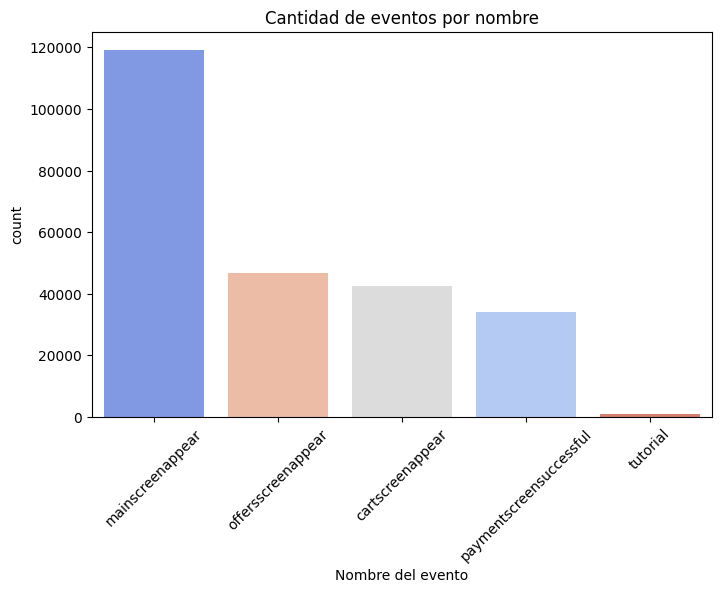

In [419]:
# Cantidad de eventos en  los regitros

event_counts = data_event['event_name'].value_counts()
print(event_counts)

# grafico de la cantidad de eventos por nombre
plt.figure(figsize=(8, 5))
sns.countplot(data=data_event, x='event_name', order=data_event['event_name'].value_counts().index, palette='coolwarm',hue='event_name')
plt.xlabel('Nombre del evento')
plt.title('Cantidad de eventos por nombre')
plt.xticks(rotation=45)
plt.show()


### Analisis Preliminar

- De acuerdo a los registros, hay un 5 tipos de eventos en los cuales se encuentran:
    - ``mainscreenappear``: 119101 interacciones
    - ``offersscreenappear``: 46808 interacciones
    - ``cartscreenappear``: 42668 interacciones
    - ``paymentscreensuccessful``: 34118 interacciones
    - ``tutorial``: 1018 interacciones
Esto desglosa un total de 211713 interacciones en la aplicación  y nos da una ida de el comportamiento de los usuarios en la aplicación.

- La mayoría de los eventos son ``mainscreenappear`` y ``offersscreenappear``, lo que indica que los usuarios pasan más tiempo en la pantalla principal y en la pantalla de ofertas.

## ¿Cuántos usuarios hay en los registros?



In [420]:
# Cantidad de usuarios en los registros

user_counts = data_event['device_id_hash'].nunique()
print(f'Cantidad de usuarios únicos: {user_counts}')



Cantidad de usuarios únicos: 7551


### Cantidad de usuarios únicos
- En total hay ``7551 usuarios únicos en los registros``, lo que indica que la aplicación tiene una base de usuarios relativamente pequeña. Esto puede ser un factor limitante al analizar el comportamiento de los usuarios y la efectividad del experimento A/A/B.

# ¿Cuál es el promedio de eventos por usuario?

           device_id_hash  event_count
0        6888746892508752            1
1        6909561520679493            5
2        6922444491712477           47
3        7435777799948366            6
4        7702139951469979          137
...                   ...          ...
7546  9217594193087726423            9
7547  9219463515465815368           17
7548  9220879493065341500            7
7549  9221926045299980007            7
7550  9222603179720523844           59

[7551 rows x 2 columns]


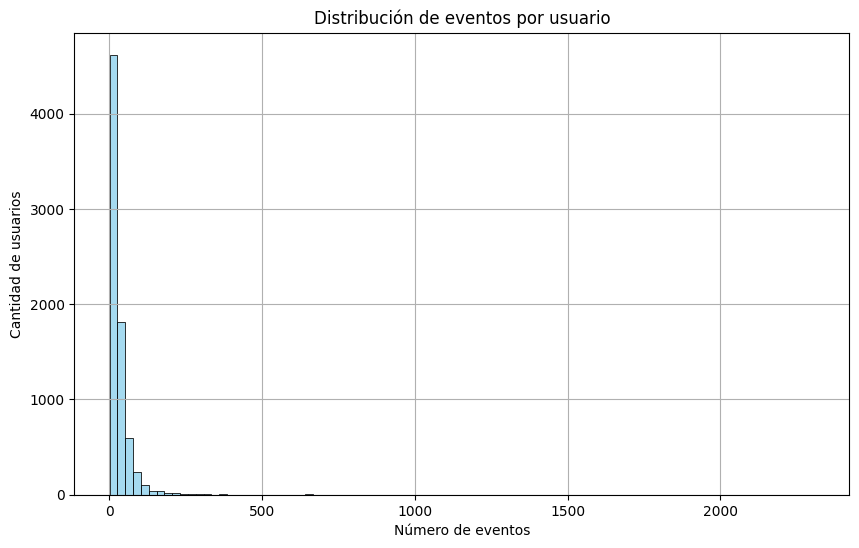

In [421]:
# Cantidad de eventos por usuario

user_event_counts = data_event.groupby('device_id_hash')['event_name'].count().reset_index()
user_event_counts.columns = ['device_id_hash', 'event_count']
print(user_event_counts)

# grafico de la cantidad de eventos por usuario

plt.figure(figsize=(10, 6))
sns.histplot(user_event_counts['event_count'], bins=90, color='skyblue')
plt.title('Distribución de eventos por usuario')
plt.xlabel('Número de eventos')
plt.ylabel('Cantidad de usuarios')
plt.grid(True)
plt.show()


In [422]:
# Promedio de eventos por usuario
avg_events = user_event_counts['event_count'].mean()
print(f"\nPromedio de eventos por usuario: {avg_events:.2f}")

# Moda de los datos

user_events_mode = user_event_counts['event_count'].mode()

print(f"\nModa de eventos por usuario: {user_events_mode[0]:.2f}")



Promedio de eventos por usuario: 32.28

Moda de eventos por usuario: 5.00


### Análisis de eventos por usuario

- El promedio de eventos por usuario es de ``32 interacciones`` , lo que indica que los usuarios interactúan con la aplicación en múltiples ocasiones. Esto sugiere que la aplicación tiene un nivel de compromiso moderado, ya que los usuarios están dispuestos a interactuar con ella en varias ocasiones.
- Teniendo en cuenta que la distribucion no representan un comportamiento normal se hace necesario recurrir a la 'moda' de los datos para saber con certeza la duracion de cada usuario real.

- La moda de eventos por usuario es de ``5 interacciones`` , lo que significa que la mayoría de los usuarios tienden a interactuar con la aplicación alrededor de 5 veces. Esto puede ser un indicador de que hay un grupo de usuarios muy activos que utilizan la aplicación con frecuencia, mientras que otros pueden estar menos comprometidos.